## I&I

In [61]:
import pandas as pd
import numpy as np
import glob

from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split, KFold
% matplotlib inline

In [ ]:
# TODO:
    # extract features
    # convert to libsvm

In [2]:
cd /home/gidi/nbs/Road\ Track

/home/gidi/nbs/Road Track


## Read Data

In [4]:
f=glob.glob('*.xlsx')
excel=pd.ExcelFile(f[0])

/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:14: FutureWarning: to_datetime is deprecated. Use pd.to_datetime(...)
  


Driver_Door
BackLeft_Door
Seat_Driver
Ignition_On
Bump1
Bump2
Regular_Road
High_Way
Acceleration
Stop1


/home/gidi/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:528: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


Stop2
Stop3
Dirt_Road
ZigZag


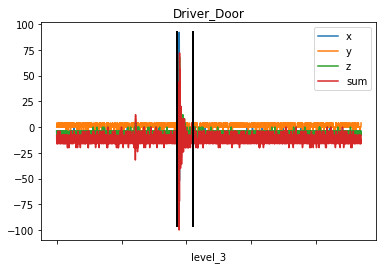

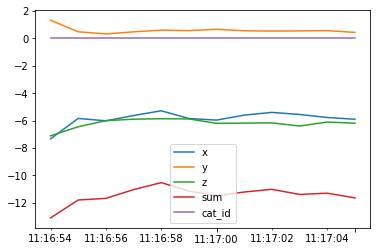

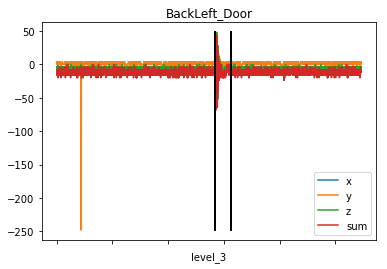

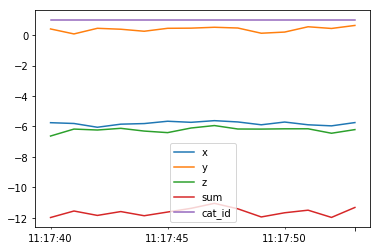

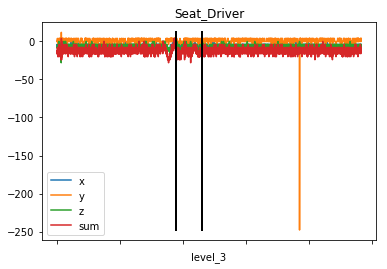

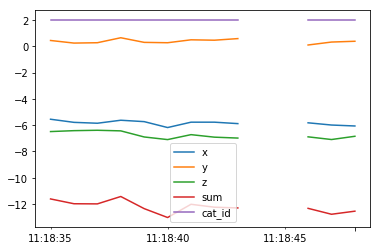

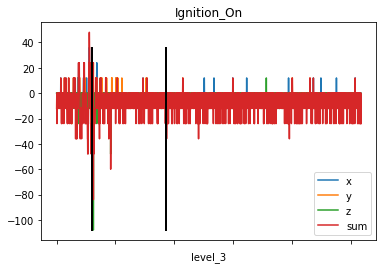

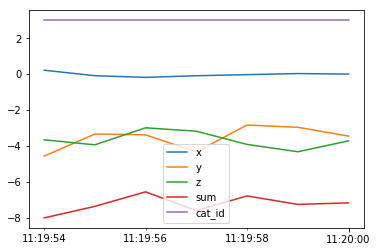

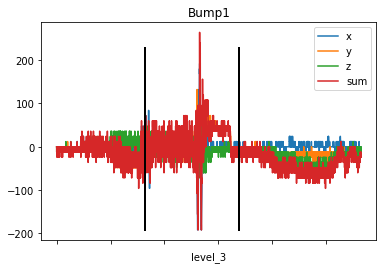

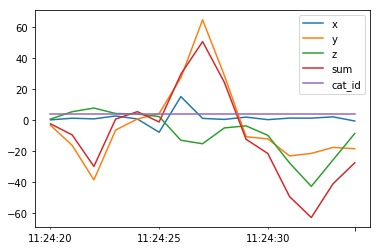

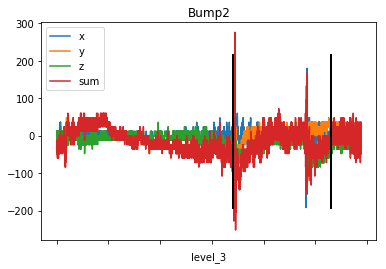

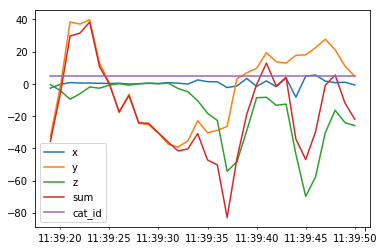

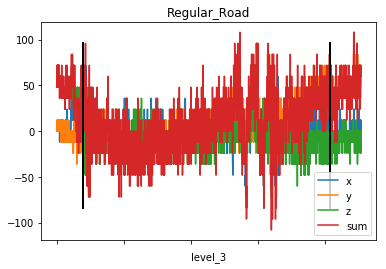

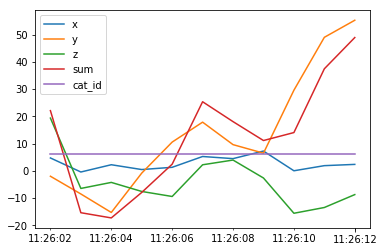

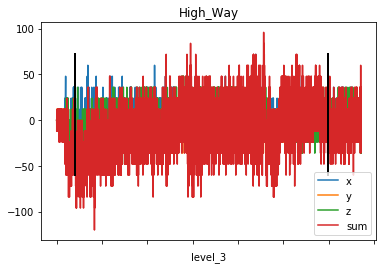

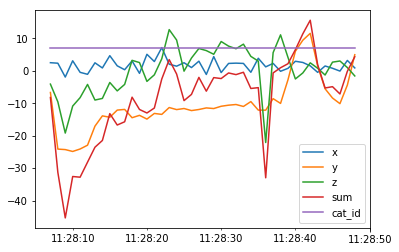

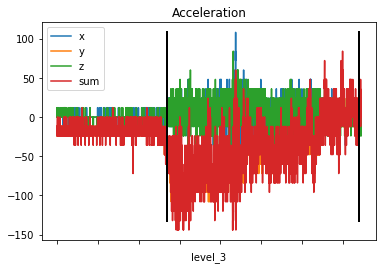

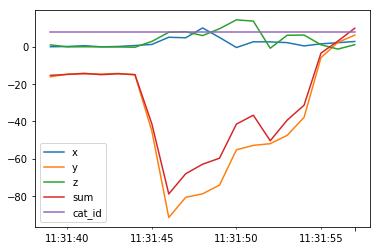

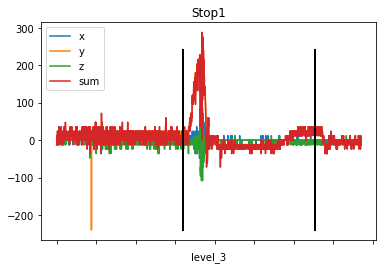

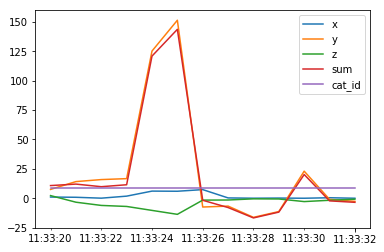

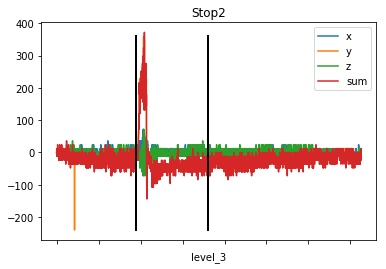

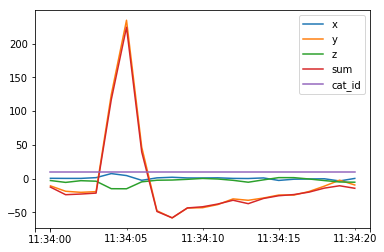

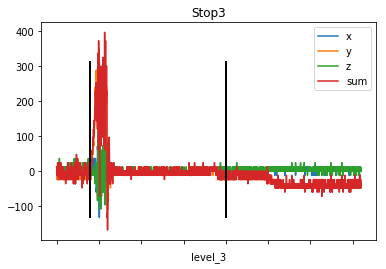

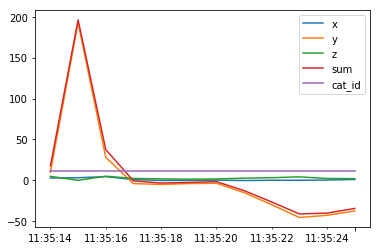

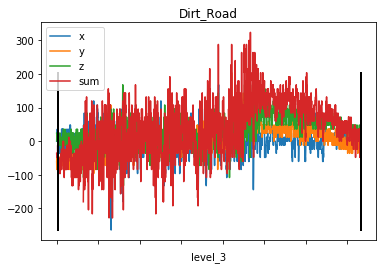

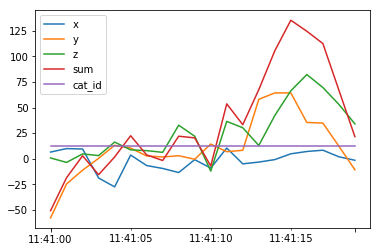

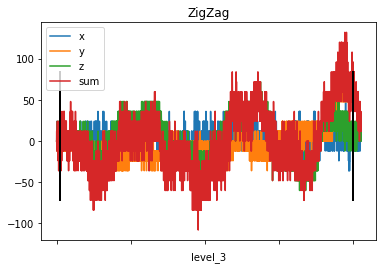

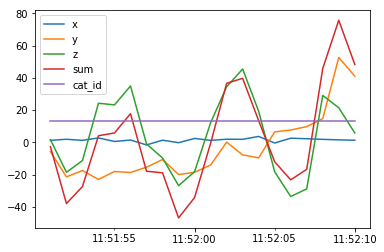

In [24]:
df_dict={}
for i,name in enumerate(excel.sheet_names):
    df=excel.parse(name)
    df=df.reset_index()
    df=df.set_index(df.columns[3])
    start_end=np.where(df['Unnamed: 3'].isin(['Start', 'End']))
    df= df[['x','y','z']].apply(pd.to_numeric, errors='coerce')
    df.x=df.x+240
    df['sum'] = df['x']+df['y']+df['z']
    ax=df.plot(title=name)

    ax.plot([ start_end[0][0],start_end[0][0]], [min(df[['x','y','z']].min()),max(df[['x','y','z']].max())], 'k-', lw=2)
    ax.plot([ start_end[0][1],start_end[0][1]], [min(df[['x','y','z']].min()),max(df[['x','y','z']].max())], 'k-', lw=2)
    df.index=df.index.to_datetime()
    print(name)
    df_dict[name]=df
    df_dict[name]['cat']=name # add category
    df_dict[name]['cat_id']=i
    df.resample('s').mean().plot() # resample by the second
    #a=df.resample('1S')
    #a.plot()

In [198]:
min(df[['x','y','z']].min())

x   -276
y    -36
z    -72
dtype: int64

In [25]:
research_df=df_dict['ZigZag'].append(df_dict['Dirt_Road'])

In [34]:
resampled=research_df.resample('s').mean().dropna()

In [50]:
six_features=research_df.resample('s').std().dropna().join(resampled, lsuffix='_std', rsuffix='_mean')

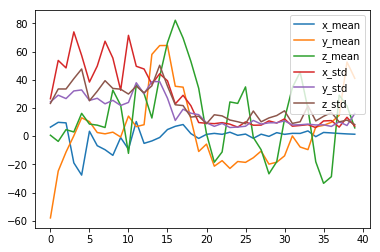

In [135]:
six_features.reset_index()[features].plot()

## Modeling

### basic

In [122]:
trn,test = train_test_split(six_features)

In [123]:
model=LogisticRegression()

In [124]:
model.fit(trn[['x_mean','y_mean','z_mean','x_std','y_std','z_std']],trn[['cat_id_mean']])

/home/gidi/anaconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:578: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [125]:
model.score(test[['x_mean','y_mean','z_mean','x_std','y_std','z_std']],test[['cat_id_mean']])

0.8

In [127]:
model.intercept_

array([1.41659769])

### Kfold

In [88]:
len(six_features)

40

In [66]:
features=['x_mean','y_mean','z_mean','x_std','y_std','z_std']

In [95]:
# proper KFold
kf = KFold(5,shuffle=True,random_state=0)
for samples_train, samples_test in kf.split(six_features):
    model=LogisticRegression()
    X_train,X_valid, y_train,y_valid=six_features[features].iloc[samples_train],six_features[features].iloc[samples_test]\
        ,six_features.cat_id_mean[samples_train],six_features.cat_id_mean[samples_test]
    model.fit(X_train,y_train)
    print(model.score(X_valid,y_valid))

0.875
0.875
0.875
1.0
0.625


## Lasso

In [ ]:

import time

import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LassoCV, LassoLarsCV, LassoLarsIC
from sklearn import datasets

In [111]:
diabetes = datasets.load_diabetes()
X = six_features[features]
y = six_features.cat_id_mean


In [108]:
X = np.c_[X, rng.randn(X.shape[0], 14)]  # add some bad features

# normalize data as done by Lars to allow for comparison
X /= np.sqrt(np.sum(X ** 2, axis=0))

In [112]:
np.concatenate(X, rng.randn(X.shape[0], 14))

TypeError: only integer scalar arrays can be converted to a scalar index

In [113]:
X.shape

(40, 6)

/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:28: RuntimeWarning: divide by zero encountered in log10


Computing regularization path using the coordinate descent lasso...
Computing regularization path using the Lars lasso...


/home/gidi/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:81: RuntimeWarning: divide by zero encountered in log10


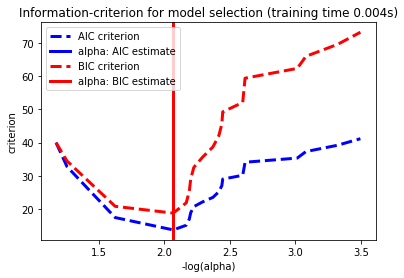

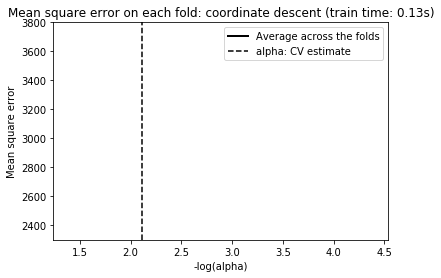

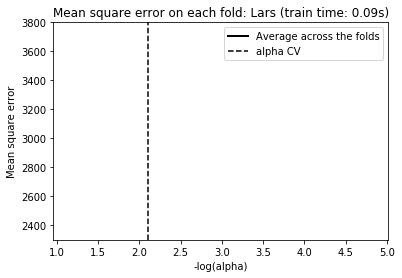

In [105]:
rng = np.random.RandomState(42)

# #############################################################################
# LassoLarsIC: least angle regression with BIC/AIC criterion

model_bic = LassoLarsIC(criterion='bic')
t1 = time.time()
model_bic.fit(X, y)
t_bic = time.time() - t1
alpha_bic_ = model_bic.alpha_

model_aic = LassoLarsIC(criterion='aic')
model_aic.fit(X, y)
alpha_aic_ = model_aic.alpha_


def plot_ic_criterion(model, name, color):
    alpha_ = model.alpha_
    alphas_ = model.alphas_
    criterion_ = model.criterion_
    plt.plot(-np.log10(alphas_), criterion_, '--', color=color,
             linewidth=3, label='%s criterion' % name)
    plt.axvline(-np.log10(alpha_), color=color, linewidth=3,
                label='alpha: %s estimate' % name)
    plt.xlabel('-log(alpha)')
    plt.ylabel('criterion')

plt.figure()
plot_ic_criterion(model_aic, 'AIC', 'b')
plot_ic_criterion(model_bic, 'BIC', 'r')
plt.legend()
plt.title('Information-criterion for model selection (training time %.3fs)' % t_bic)

# #############################################################################
# LassoCV: coordinate descent

# Compute paths
print("Computing regularization path using the coordinate descent lasso...")
t1 = time.time()
model = LassoCV(cv=20).fit(X, y)
t_lasso_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.alphas_)

plt.figure()
ymin, ymax = 2300, 3800
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k',label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k',label='alpha: CV estimate')

plt.legend()
plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: coordinate descent ' '(train time: %.2fs)' % t_lasso_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

# #############################################################################
# LassoLarsCV: least angle regression

# Compute paths
print("Computing regularization path using the Lars lasso...")
t1 = time.time()
model = LassoLarsCV(cv=20).fit(X, y)
t_lasso_lars_cv = time.time() - t1

# Display results
m_log_alphas = -np.log10(model.cv_alphas_)

plt.figure()
plt.plot(m_log_alphas, model.mse_path_, ':')
plt.plot(m_log_alphas, model.mse_path_.mean(axis=-1), 'k', label='Average across the folds', linewidth=2)
plt.axvline(-np.log10(model.alpha_), linestyle='--', color='k', label='alpha CV')
plt.legend()

plt.xlabel('-log(alpha)')
plt.ylabel('Mean square error')
plt.title('Mean square error on each fold: Lars (train time: %.2fs)'
          % t_lasso_lars_cv)
plt.axis('tight')
plt.ylim(ymin, ymax)

plt.show()

## More

In [37]:
a=excel.parse(name)

In [39]:
a.reset_index()

,level_0,level_1,level_2,level_3,level_4,level_5,x,y,z,Unnamed: 3
0,Pushed device at line 5880,"DATA before push, line 2927 pushed the device",NaN,11:51:51.148,27,R,-240,0,0,NaN
1,NaN,NaN,NaN,11:51:51.148,58,R,-228,0,0,NaN
2,NaN,NaN,NaN,11:51:51.148,58,R,-228,-12,0,NaN
3,NaN,NaN,NaN,11:51:51.148,58,R,-228,-12,0,NaN
4,NaN,NaN,NaN,11:51:51.148,58,R,-228,-12,0,NaN
5,NaN,NaN,NaN,11:51:51.148,103,R,-216,-12,0,NaN
6,NaN,NaN,NaN,11:51:51.148,58,R,-228,-12,0,NaN
7,NaN,NaN,NaN,11:51:51.148,58,R,-228,-12,0,NaN
8,NaN,NaN,NaN,11:51:51.148,67,R,-228,-12,12,NaN
9,NaN,NaN,NaN,11:51:51.165,58,R,-228,0,0,NaN


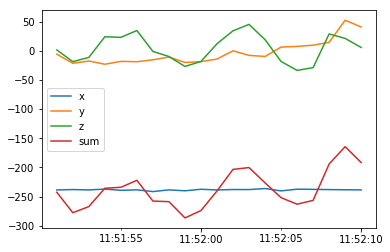

In [30]:
df.resample('s').mean().plot()

In [57]:
driver_door=excel.parse('Driver_Door')
driver_door=driver_door.reset_index()
driver_door=driver_door.set_index(driver_door.columns[3])
#driver_door.set_index(driver_door.columns[3])

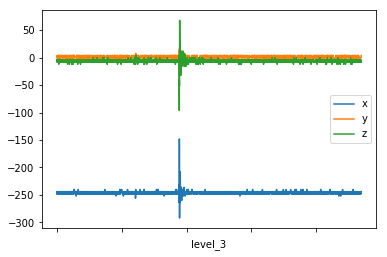

In [139]:

driver_door[['x','y','z']].apply(pd.to_numeric, errors='coerce').plot()

In [132]:
pd.to_numeric(driver_door[['z']],errors='coerce').plot()

TypeError: arg must be a list, tuple, 1-d array, or Series

In [73]:
driver_door.iloc[1646,:]

level_0        NaN
level_1        NaN
level_2        NaN
level_4         11
level_5          R
x             -248
y                0
z               -4
Unnamed: 3     NaN
Name: 11:16:58.010, dtype: object

## Altair plots

In [91]:
import altair as alt
from altair.expr import datum
from vega_datasets import data
%matplotlib inline

stocks = data.stocks()

chart = alt.Chart(driver_door[['x','y','z']]).mark_line(interpolate='step-after').encode(
    x = 'date',
    y = 'price'
).transform_filter(
    datum.symbol =='GOOG'
)

In [46]:
driver_door.columns

Index(['x', 'y', 'z', 'Unnamed: 3'], dtype='object')

In [87]:
cars = alt.load_dataset('cars')

In [106]:
driver_door.head()

,level_0,level_1,level_2,level_4,level_5,x,y,z,Unnamed: 3
level_3,,,,,,,,,
11:16:54.956,Pushed device at line 5880,"DATA before push, line 2927 pushed the device",NaN,14,R,-244,0,-4,NaN
11:16:54.956,NaN,NaN,NaN,8,R,-248,0,-8,NaN
11:16:54.956,NaN,NaN,NaN,8,R,-248,0,-8,NaN
11:16:54.956,NaN,NaN,NaN,8,R,-244,0,-8,NaN
11:16:54.956,NaN,NaN,NaN,8,R,-248,0,-8,NaN


In [131]:
driver_door[['x','y','z']].head()

,x,y,z
level_3,,,
11:16:54.956,-244,0,-4
11:16:54.956,-248,0,-8
11:16:54.956,-248,0,-8
11:16:54.956,-244,0,-8
11:16:54.956,-248,0,-8


In [129]:
driver_door[['x','y','z']].plot()

TypeError: Empty 'DataFrame': no numeric data to plot

In [127]:
chart.configure_scale(bandSize=60)

SchemaValidationError: Invalid specification

        altair.vegalite.v2.schema.core.ScaleConfig, validating 'additionalProperties'

        Additional properties are not allowed ('bandSize' was unexpected)
        

In [125]:
brush = alt.selection_interval()

alt.Chart(driver_door[['x','y','z']]).mark_line().encode(
    x='x',
    y='y',
).properties(
    selection=brush
)

<VegaLite 2 object>

In [99]:
import altair as alt

data = "https://frdata.wikimedia.org/donationdata-vs-day.csv"

chart = alt.Chart(data).mark_line().encode(
    alt.X(
        'date:T', timeUnit='monthdate',
        axis=alt.Axis(format='%B', title='Month')
    ),
    alt.Y(
        'max(ytdsum):Q', stack=None,
        axis=alt.Axis(title='Cumulative Donations')
    ),
    alt.Color('date:O', timeUnit='year', legend=alt.Legend(title='Year')),
    alt.Order('data:O', timeUnit='year')
)

## C++ LibLinear

In [2]:
cd ~/cloned_libs/liblinear/python

/home/gidi/cloned_libs/liblinear/python


In [3]:
from liblinearutil import *

In [12]:
# Read data in LIBSVM format
y, x = svm_read_problem('../heart_scale')
m = train(y[:200], x[:200], '-c 4')
p_label, p_acc, p_val = predict(y[200:], x[200:], m)

Accuracy = 81.4286% (57/70) (classification)


In [9]:
# Construct problem in python format
# Dense data
y, x = [1,-1], [[1,0,1], [-1,0,-1]]
# Sparse data
y, x = [1,-1], [{1:1, 3:1}, {1:-1,3:-1}]
prob  = problem(y, x)
param = parameter('-c 4 -B 1')
m = train(prob, param)
predict(y, x, m)

Accuracy = 100% (2/2) (classification)


([1.0, -1.0], (100.0, 0.0, 1.0), [[0.971876990976], [-0.969729507328]])

In [10]:
# funcs
# gen_feature_nodearray, train, parameter, predict, svm_read_problem

In [14]:
# Other utility functions
save_model('heart_scale.model', m)
m = load_model('heart_scale.model')
#p_label, p_acc, p_val = predict(y, x, m, '-b 1')
#ACC, MSE, SCC = evaluations(y, p_label)

In [ ]:

# Other utility functions
save_model('heart_scale.model', m)
m = load_model('heart_scale.model')
p_label, p_acc, p_val = predict(y, x, m, '-b 1')
ACC, MSE, SCC = evaluations(y, p_label)

# Getting online help
help(train)

# The low-level use directly calls C interfaces imported by liblinear.py. Note that
# all arguments and return values are in ctypes format. You need to handle them
# carefully.

from liblinear import *
prob = problem([1,-1], [{1:1, 3:1}, {1:-1,3:-1}])
param = parameter('-c 4')
m = liblinear.train(prob, param) # m is a ctype pointer to a model
# Convert a Python-format instance to feature_nodearray, a ctypes structure
x0, max_idx = gen_feature_nodearray({1:1, 3:1})
label = liblinear.predict(m, x0)

In [11]:
m